# IMPORTS

In [7]:
import pandas as pd
import os
from tabulate import tabulate
from pandarallel import pandarallel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# CONFIGURATION

In [8]:
# PREVIEW PHASE
PREVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 100000
EXTRACT_PARQUET = False

# ANALYSE PHASE
SAMPLING_SIZE = 1000

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
PREFIX_YELP = 'yelp_academic_dataset_'

# FONCTIONS

In [9]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df

def get_words_max_frequency(reviews: pd.DataFrame, max_frequency = 1):
    words = {}
    for index in reviews.index:
        for token in reviews.loc[index, 'tokens']:
            if not token in words:
                words[token] = 1
            else:
                words[token] = words[token] + 1
    under = [token for token, count in words.items() if count <= max_frequency]
    upper = [token for token, count in words.items() if count > max_frequency]
    
    return [token for token, count in words.items() if count <= max_frequency], len(upper)      

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # normalization
    text = text.lower()

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Stops Words
    stops = stopwords.words('english')
    tokens = [token for token in tokens if not token in stops]

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    return tokens

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

# PREVISUALISATION DES DATASETS

In [10]:
files = list_files(ORIGINAL_DATASET_DIR)
files

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb


{'business': 'data/original/yelp_dataset/yelp_academic_dataset_business.json',
 'checkin': 'data/original/yelp_dataset/yelp_academic_dataset_checkin.json',
 'review': 'data/original/yelp_dataset/yelp_academic_dataset_review.json',
 'tip': 'data/original/yelp_dataset/yelp_academic_dataset_tip.json',
 'user': 'data/original/yelp_dataset/yelp_academic_dataset_user.json'}

In [11]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
771,sWCCxY1-9B1FGlSVeQvnHg,CD Roma Restaurant,1462 66th St N,St Petersburg,FL,33710,27.785489,-82.730295,4.0,125,1,"{'RestaurantsDelivery': 'True', 'WiFi': 'u'fre...","Restaurants, Wine Bars, Italian, Food, Sandwic...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
478,fCRGXD-TTLgNhaC4mVFFJQ,El Con Health & Wellness Center,3402 E Broadway Blvd,Tucson,AZ,85716,32.221262,-110.920068,4.5,18,1,"{'AcceptsInsurance': 'True', 'WheelchairAccess...","Beauty & Spas, Nutritionists, Medical Spas, La...","{'Tuesday': '8:0-17:0', 'Wednesday': '8:0-17:0..."
74,9Rww8yE6Dm4dSMEq09nwXg,Holly Nails & Spa,9101 Belcher Rd,Pinellas Park,FL,33782,27.855347,-82.736308,4.5,16,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Health & Medical, Personal Care Services, Beau...","{'Tuesday': '9:30-19:0', 'Wednesday': '9:30-19..."
981,g7GCbnZC_HKO0ybNt7NXBw,Popeyes Louisiana Kitchen,443 Opry Mills Dr,Nashville,TN,37214,36.202427,-86.692898,1.0,6,1,"{'RestaurantsDelivery': 'None', 'RestaurantsTa...","Chicken Wings, Fast Food, Restaurants",None
507,cvrIE1rLPWk-Nxb_ZNv5lA,Candlewood Suites Tucson,1995 W River Rd,Tucson,AZ,85704,32.303742,-111.009324,4.5,29,1,"{'BusinessAcceptsCreditCards': 'True', 'WiFi':...","Party & Event Planning, Event Planning & Servi...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
343,-99aS7t1izJrDtgSUyvoxg,"2010-11-11 18:07:10, 2010-11-12 14:50:08, 2011..."
719,-L3E_h6OUJ7kRW2EDMFESQ,"2015-02-26 04:16:09, 2015-04-04 03:35:21, 2015..."
873,-Q99xmgUqlJ38jdUNOiYLw,"2011-05-15 01:10:34, 2011-05-22 04:44:37, 2011..."
697,-KUu_Rl4UepNCIyWTJYbow,"2014-02-06 23:40:16, 2014-03-25 16:28:21, 2014..."
718,-KyQ_Bu21JNphNtxz-Jj-g,"2010-06-25 19:03:58, 2010-07-18 00:20:26, 2010..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
483,e_f_4_U6Hlr0znVQfUbzEg,6mnrwzi5HM-WMUfXL7EYgg,cdqTpsr110wSNPMtLCPh7A,5,0,1,0,SRS is truly an exceptional management company...,2016-11-22 03:53:44
230,lt-tsizQin_wNCkQv71YPQ,qWSAH4MzFbHV6UsseJVlZg,dUctvEfHQccW_uxtRup2QQ,1,0,0,0,I had a horrible experience here. The waiter w...,2015-12-20 20:36:40
624,Rzxws4o77wDp3dGw7Y1V0A,_kcHxYPXRYjU4hk2xtCO0w,jtsckI_01hlbGLpEFwJu0A,5,5,1,2,We came here for an early mothers day celebrat...,2015-06-09 16:39:35
33,xdQe2E8jR6pLA07p1aYtKA,yFuE8SPF-d1GXJUWYgKtzg,X8lfGPagfLzfOsx0k08NRQ,5,0,0,0,Took my vehicle here for some work a few years...,2017-05-13 14:15:29
140,27CYrDqJIUjbOLNeKTfjDg,k3Q0ZcVuMdvA_9iDcSDWIA,pym7c6ZFEtmoH16xN2ApBg,4,0,0,0,It seems to me that whenever we have out of to...,2016-06-22 20:10:18


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
38,_YBX0Fy9pI0ktOQ9RtFhAg,nzqx3NJ1Yf-1bugLNikSCg,Hours are incorrect on Yelp. They close at 3PM...,2016-07-30 20:44:04,0
291,JnSlKs__M6IL_r_yet1_9g,Bxmhm659VqrQYHc0hiku5w,Love there pizza!!!!!,2016-12-18 19:23:09,0
513,jjHZxlSWU6hh66U9_LUB_A,KQHqDPUaAd4412_6vbRk0g,Ask for your pita toasted well done. Yum,2011-07-26 16:37:26,0
140,iNZuWjfkYJb1GvyqghOj6w,sTI1emOwk2eJPw7ka_YPXQ,Great! Rachel was awesome.,2017-09-25 15:17:08,0
939,MRa2O7cX1507JEOkijR8Ig,F7pG70kxLYt_HR6OnylgMQ,Oh yeah...Swedish Fish,2012-03-29 18:06:52,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
776,gvyYZgFdBbcT3xGjWOvZag,Frances,282,2007-05-17 01:47:17,1412,738,1129,"2010,2011,2012,2013","NvUeb5G_mSSxgKhEE_Hueg, r6dKOf0mcEZsryd7L4ZlvA...",180,...,107,89,28,70,181,389,681,681,437,89
631,TvsPmBJt_Ei1RdOtVhjjiQ,Frank,621,2008-05-13 03:05:02,701,254,279,,"AlMrV8fUuGHKLpgLmqk-Bw, HMp1Y1cSVHsIPClJBx_6lw...",27,...,3,0,0,0,14,34,15,15,9,6
480,XcwBT1a_5ZjdaPZTZOhN-Q,Tung,528,2011-04-03 09:22:14,571,141,259,"2016,2017,2018,2019,20,20,2021","xHo6dPuUoRyaYbqSKEh12w, B_94GAv3TTejBkYzZRhZrg...",25,...,0,0,0,0,9,36,13,13,7,4
111,I7YQFiIsO82eliq8nqsLfA,Michelle,885,2010-04-26 20:45:56,2501,485,767,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...","sMIFUM1v-dxzO8_iPwVBKw, 3xFGPEzgK-WNlYnO2QOzdQ...",50,...,13,1,1,4,29,40,72,72,26,7
675,Wttx9bqHkOnRXokSrAjY_w,Adam,222,2010-01-03 11:18:29,284,38,68,"2015,2016,2017","T4e0ERTywJaCyxty19ZGrQ, IQTEZwxCSuEuDykrLiltRQ...",4,...,1,1,0,0,2,3,0,0,3,0


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

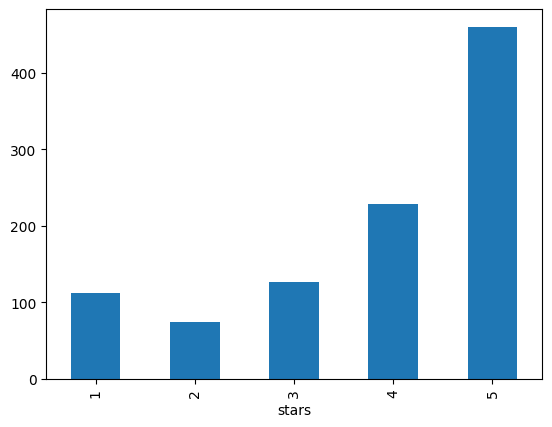

In [12]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [13]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [14]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

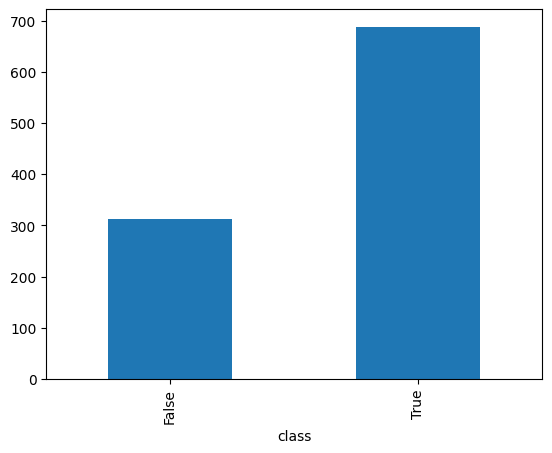

In [15]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 3
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

# EXTRACTION GOOD/BAD REVIEWS DES RESTAURANTS

## CATEGORIES DE BUSINESS

In [16]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

28258     [Coffee & Tea, Breakfast & Brunch, Restaurants...
53461     [Shopping, Fashion, Building Supplies, Home Se...
134989    [Oil Change Stations, Tires, Auto Repair, Auto...
73159     [Event Planning & Services, Local Flavor, Food...
59181     [Oral Surgeons, Dentists, Health & Medical, Ge...
Name: _cats, dtype: object

In [17]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [18]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Pop-Up Restaurants', 'Restaurant Supplies', 'Restaurants']

In [19]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Comfort Food',
 'Food',
 'Food Court',
 'Ethnic Food',
 'Food Delivery Services',
 'Seafood Markets',
 'Seafood',
 'Specialty Food',
 'Food Stands',
 'Food Trucks',
 'Live/Raw Food',
 'Imported Food',
 'Food Tours',
 'Food Banks',
 'Do-It-Yourself Food',
 'Fast Food',
 'Soul Food']

## REDUCTION DU DATAFRAME REVIEW ET SAUVEGARDE

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation en bad/good reviews (bad <= stars = 3 < good)
- Ne garder que text et séparer en 2 fichiers good/bad news

In [20]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
restaurants_ids[0:10]

['MTSW4McQd7CbVtyjqoe9mw',
 'CF33F8-E6oudUQ46HnavjQ',
 'k0hlBqXX-Bt0vf1op7Jr1w',
 'bBDDEgkFA1Otx9Lfe7BZUQ',
 'eEOYSgkmpB90uNA7lDOMRA',
 'il_Ro8jwPlHresjw9EGmBg',
 '0bPLkL0QhhPO5kt1_EXmNQ',
 'MUTTqe8uqyMdBl186RmNeA',
 'ROeacJQwBeh05Rqg7F6TCg',
 'WKMJwqnfZKsAae75RMP6jA']

In [21]:
append = False
good_reviews_file = WORK_DATASET_DIR + 'good_reviews.parquet'
bad_reviews_file = WORK_DATASET_DIR + 'bad_reviews.parquet'

if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=100000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews['class'] = restaurant_reviews['stars'] > 3
        restaurant_reviews = restaurant_reviews.loc[:, ['text', 'class']]
    
        good_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == True]['text'])
        bad_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == False]['text'])
    
        good_reviews.to_parquet(good_reviews_file, engine='fastparquet', append=append)
        bad_reviews.to_parquet(bad_reviews_file, engine='fastparquet', append=append)
        append = True

# TOKENIZATION ET ANALYSE DES BAD REVIEWS 

In [23]:
def treat_reviews(reviews_file, min_words_frequency = 4):

    # load dataframe and display head
    print('Chargement du dataset\n=================\n')
    reviews = pd.read_parquet(reviews_file)
    display(reviews.head())

    # Initialize paralellize and sampling
    print('\nTokenizisation\n=================\n')
    pandarallel.initialize(progress_bar=True)
    if SAMPLING_SIZE:
        reviews = reviews.sample(SAMPLING_SIZE, random_state=0)
    
    # Preprocess (tokenize, lower, lemmatization)
    reviews['tokens'] = reviews['text'].parallel_apply(preprocess_text)
    reviews.drop(columns=['text'], inplace=True)
    
    # Remove words by frequency
    print(f'\nSuppression des mot par fréquence d\'apparation (minimun={min_words_frequency})\n=================\n')
    words_to_drop, nb_tokens = get_words_max_frequency(reviews, min_words_frequency - 1)
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(words_to_drop,))

    # View result sample
    print('\nEchantillon du resultat\n=================\n')
    display(reviews.sample(5))

    # Calc and view text lengths
    print('\nAnalyse des longeurs de text\n=================\n')
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()
    reviews.boxplot(column='text_len', showfliers=True)

    total_text_len = reviews['text_len'].sum()

    print(f'Nombre de tokens dans le dataframe: {nb_tokens}')
    print(f'Longeur total du texte dans le dataframe: {total_text_len}')
    print('')

    # Visualisation Word clound on sample
    print(f'\nVisualisation du nuage de mot d\'un échantillon de {SAMPLING_SIZE} lignes\n=================\n')
    sample_text = ' '.join(reviews.sample(SAMPLING_SIZE, random_state=0)['tokens'].str.join(' ').values)
    word_cloud(text=sample_text)

Chargement du dataset



,text
index,
0,"If you decide to eat here, just be aware it is..."
2,Family diner. Had the buffet. Eclectic assortm...
5,I am a long term frequent customer of this est...
9,Had a party of 6 here for hibachi. Our waitres...
21,"Upland is a brewery based out of Bloomington, ..."



Tokenizisation

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/



Suppression des mot par fréquence d'apparation (minimun=5)




Echantillon du resultat



,tokens
index,
3243540,"[recently, stop, mother, day, brunch, say, sur..."
2974795,"[really, want, like, place, great, thing, hear..."
6178758,"[call, place, go, order, guy, rude, like, job,..."
3564293,"[family, visit, location, day, sesame, place, ..."
6515153,"[two, reason, come, 1, trip, diner, close, 2, ..."



Analyse des longeurs de text

Nombre de tokens dans le dataframe: 1683
Longeur total du texte dans le dataframe: 324980


Visualisation du nuage de mot d'un échantillon de 1000 lignes



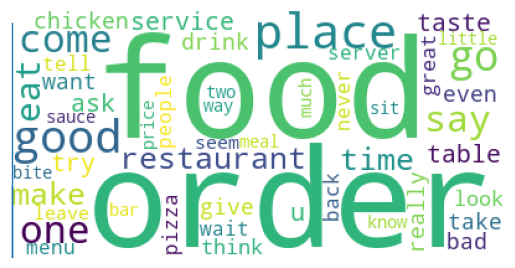

In [24]:
treat_reviews(bad_reviews_file, 5)